In [43]:
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from data import get_dataloaders
from utils.checkpoint import save, restore
from utils.loops import train, evaluate
from utils.logger import Logger
from vgg import VGG
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:

hparams = {
    "net": "VGG_8",
    "name": "VGG_8_Devanagari",
    "batch_size": 32,
    "n_epochs": 20,
    "database_path": "./Devanagari",
    "num_classes": 46,
    'num_workers': 0,
    "start_epoch": 0,
    "restore_epoch": None,
    "model_save_dir": './checkpoints/VGG_8_Devanagari',
    "lr": 0.01,
    "drop": 0.2,
    
}

In [4]:
trainloader, valloader, testloader = get_dataloaders(
        path=hparams["database_path"],
        batch_size=hparams["batch_size"],
        num_workers=hparams["num_workers"],
    )

In [48]:
labels = []
path_ = os.path.join(hparams["database_path"], "train")
for character in os.listdir(path_):
    labels.append(character.split('_')[-1])

In [5]:
net = VGG(arch=((1, 64), (1, 128), (1, 256), (1, 512), (1, 512)), lr=hparams["lr"], drop=hparams["drop"],num_classes=hparams["num_classes"])

logger = Logger()
if hparams["restore_epoch"]:
    restore(net, logger, hparams)


Restore point unavailable. Training from scratch.


e:\Anaconda\TestML\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
net = net.to(device)

learning_rate = float(hparams["lr"])
scaler = GradScaler()

optimizer = torch.optim.SGD(
    net.parameters(),
    lr=learning_rate,
    momentum=0.9,
    nesterov=True,
    weight_decay=0.0001,
)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.75, patience=5, verbose=True
)

criterion = nn.CrossEntropyLoss()

In [8]:
print("Training", hparams["name"], "on", device)

for epoch in range(hparams["start_epoch"], hparams["n_epochs"]):
    acc_tr, loss_tr = train(net, trainloader, criterion, optimizer, scaler)
    logger.loss_train.append(loss_tr)
    logger.acc_train.append(acc_tr)

    acc_v, loss_v, _ = evaluate(net, valloader, criterion)
    logger.loss_val.append(loss_v)
    logger.acc_val.append(acc_v)

    # Update learning rate
    scheduler.step(loss_v)

    print(f"Epoch {epoch + 1:02} Train Accuracy: {acc_tr:2.4}, Val Accuracy: {acc_v:2.6}")

else:
    save(net, logger, hparams, epoch + 1)

Training VGG_8_Devanagari on cuda:0
Epoch 01 Train Accuracy: 91.55, Val Accuracy: 97.8052
Epoch 02 Train Accuracy: 98.06, Val Accuracy: 98.5756
Epoch 03 Train Accuracy: 98.83, Val Accuracy: 98.3285
Epoch 04 Train Accuracy: 99.23, Val Accuracy: 98.8081
Epoch 05 Train Accuracy: 99.45, Val Accuracy: 98.75
Epoch 06 Train Accuracy: 99.65, Val Accuracy: 98.7936
Epoch 07 Train Accuracy: 99.7, Val Accuracy: 99.0116
Epoch 08 Train Accuracy: 99.68, Val Accuracy: 99.0262
Epoch 09 Train Accuracy: 99.76, Val Accuracy: 98.939
Epoch 10 Train Accuracy: 99.85, Val Accuracy: 99.0698
Epoch 11 Train Accuracy: 99.94, Val Accuracy: 99.2151
Epoch 12 Train Accuracy: 99.89, Val Accuracy: 99.2151
Epoch 00013: reducing learning rate of group 0 to 7.5000e-03.
Epoch 13 Train Accuracy: 99.93, Val Accuracy: 99.0552
Epoch 14 Train Accuracy: 99.95, Val Accuracy: 99.157
Epoch 15 Train Accuracy: 99.99, Val Accuracy: 99.1424
Epoch 16 Train Accuracy: 100.0, Val Accuracy: 99.3459
Epoch 17 Train Accuracy: 100.0, Val Accurac

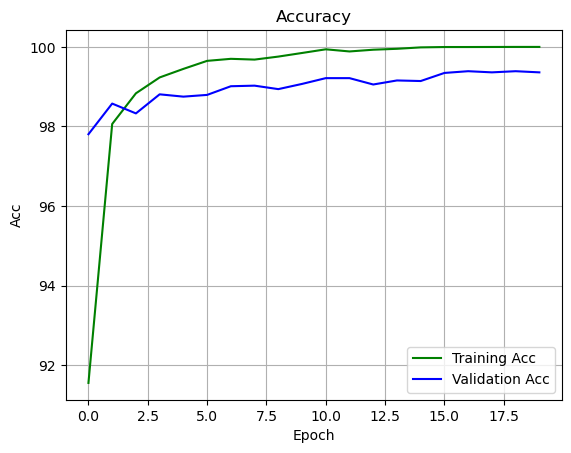

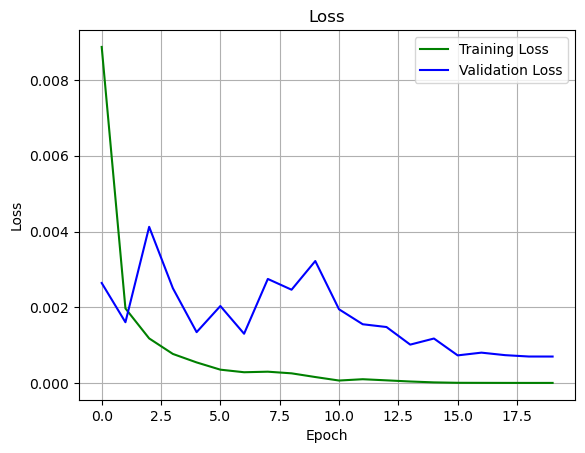

In [10]:
logger.plot(hparams, save=True, show=True)

Accuracy: 99.34782608695652
Precision: 0.99
Recall: 0.99
F1-score: 0.99


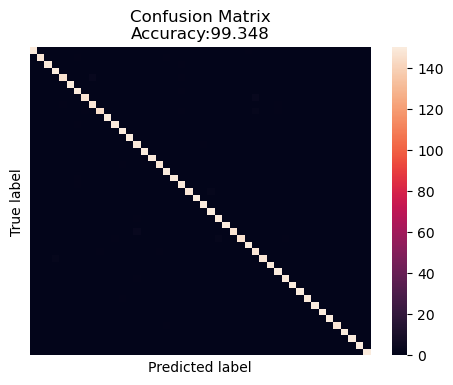

Test Loss: 0.0010148


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from math import ceil

# Calculate performance on test set
accuracy, loss, y_pred = evaluate(net, testloader, criterion)
y_test = testloader.dataset.labels

# Calculate, precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

cm = confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=False)
plt.title('Confusion Matrix\nAccuracy:{0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks([])
plt.yticks([])
plt.show()

print(f"Test Loss: {loss:2.6}")

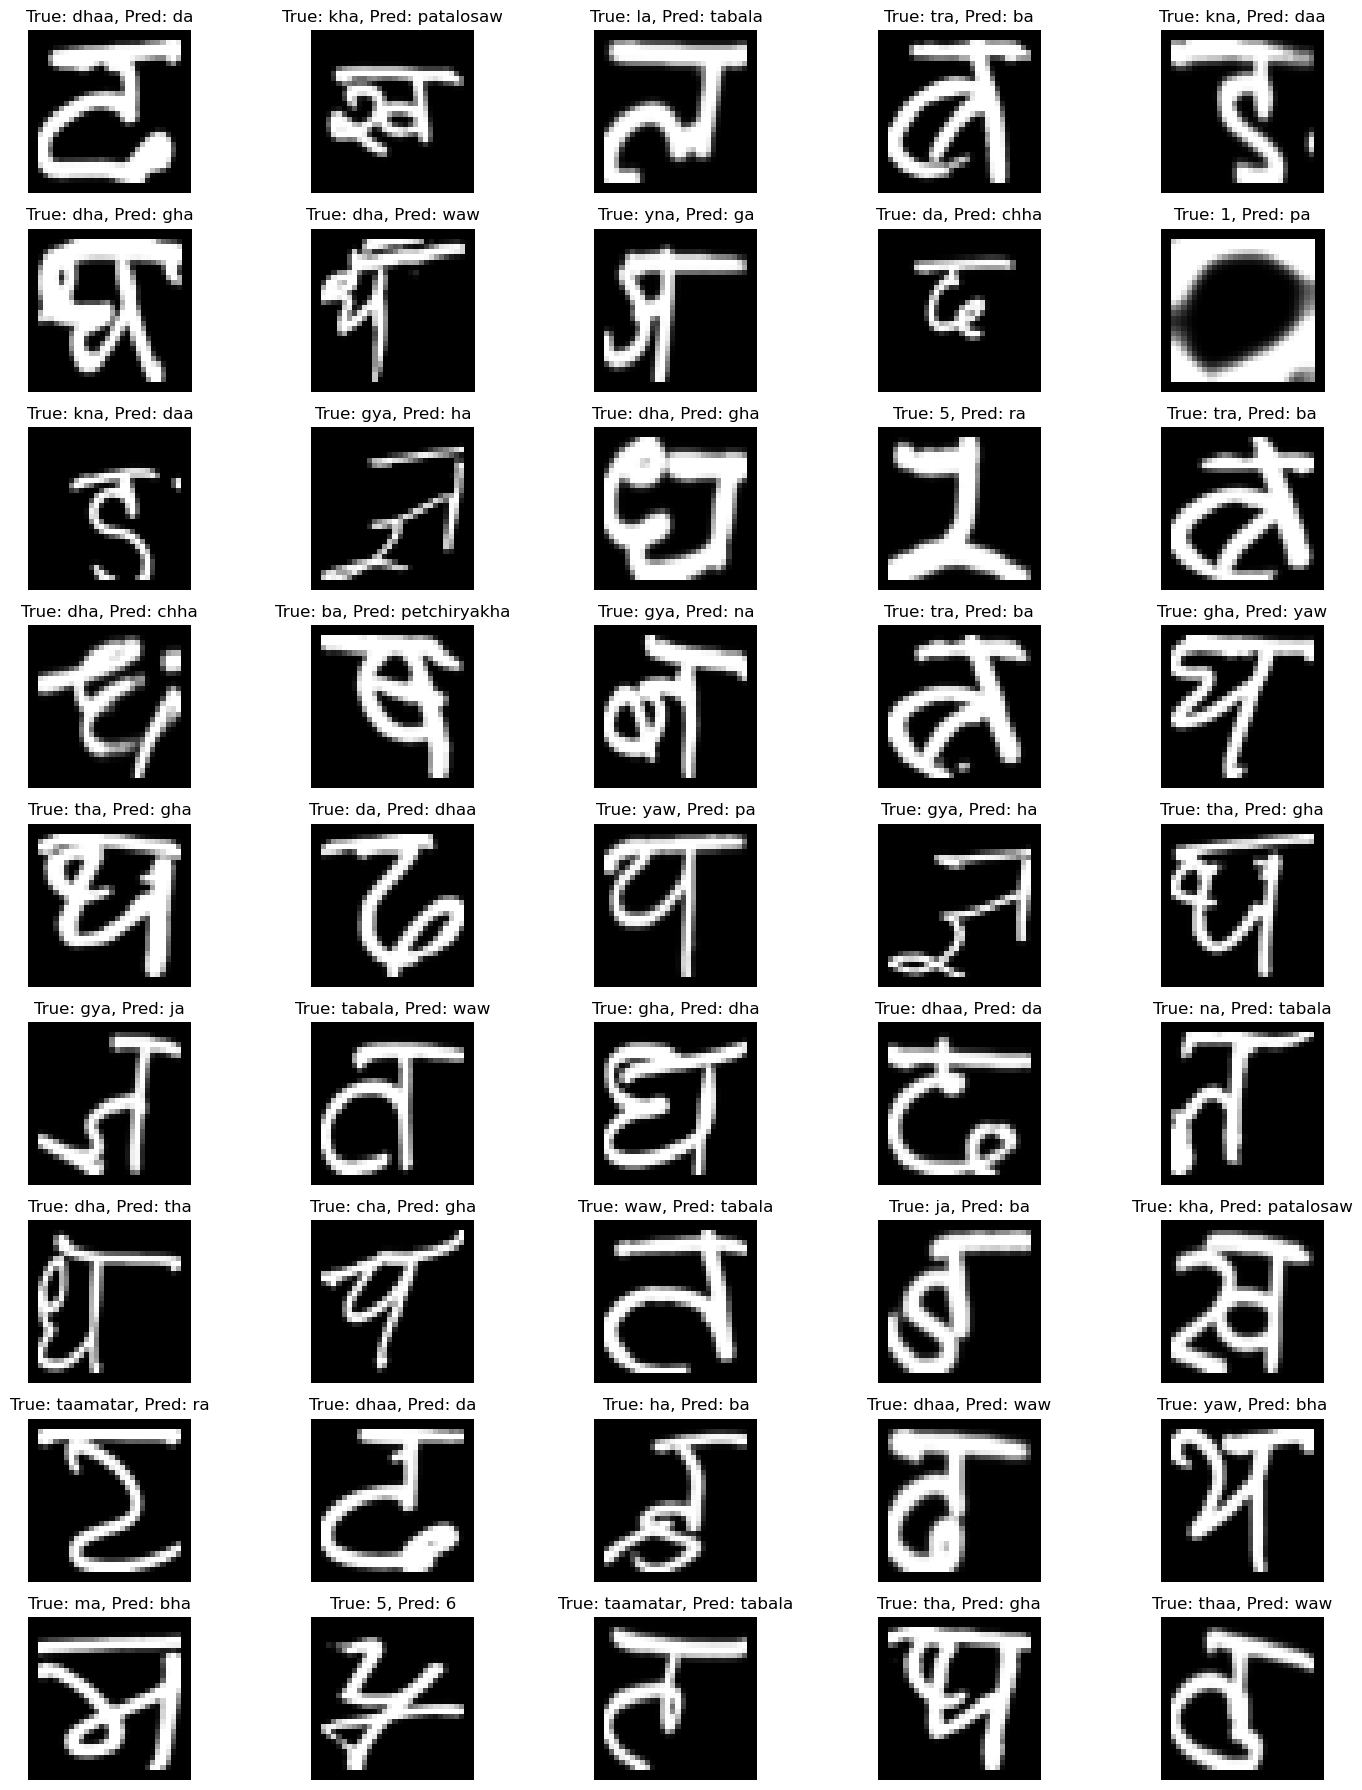

In [49]:
incorrect = np.arange(0,len(y_pred))[y_pred != y_test]
incorrect_pred = np.array(y_pred)[incorrect]
incorrect_test = y_test[incorrect]
incorrect_images = testloader.dataset.images[incorrect]

# Plotting
fig,axs = plt.subplots(ceil(len(incorrect_pred)/5), 5, figsize=(15, 2*ceil(len(incorrect_pred)/5)))
axs = axs.flatten()

for i in range(len(axs)):
    axs[i].imshow(incorrect_images[i], cmap='gray')
    axs[i].set_title(f"True: {labels[incorrect_test[i]]}, Pred: {labels[incorrect_pred[i]]}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()
